In [45]:
%load_ext autoreload
%autoreload 2
import torch
torch.cuda.empty_cache()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from collections import namedtuple
import utlis_2nd.cusdom as custom
import utlis_2nd.super_learn_task_expr2 as expr2
import warnings
read_abso_path="E:\expr\AI_STATION_WEST-master\wgan_2nd\complex_center_dataset\combined_data.pt"
results_path= "E:\expr\AI_STATION_WEST-master\wgan_2nd\expr2\expr2_1_results\expr2_1_"
warnings.filterwarnings("ignore")
#data description
Data_description=namedtuple("Data_description",["t_steps",
                                                "vesting_s",
                                                "vari_numb",
                                                "sample_rate",
                                                "freq_numb"])
#temp info
Soft_arg_temp = namedtuple("Soft_arg_temp", ["learnable", "value"])
Gumble_temp = namedtuple("Gumble_temp", ["learnable", "value"])
Sample_info = namedtuple("Sample_info", ["type", "sample_numb"])
#loss regularization
Sinkhorn_loss_info = namedtuple("Sinkhorn_loss_info", ["loss_en", "p","blur"])
Fourier_loss_info = namedtuple("Fourier_loss_info", ["loss_en","labmbda_fourier"])
Lasso_loss_info = namedtuple("Lasso_loss_info", ["loss_en", "labmbda_lasso"])

In [47]:
folder_num=3
# split data & get the t_steps
train_loader,valid_loader,test_loader,yaml_config =\
    custom.return_train_valid_test4loader(abso_path=read_abso_path,yaml_path=f"expr2_1_{folder_num}.yaml")
# look（shape）
for batch_idx, (data, target) in enumerate(train_loader):
    print("shape:", data.shape)
    print("label for csv:",target.shape)
    break


load data & read yaml
shape: torch.Size([256, 100, 9])
label for csv: torch.Size([256])


In [48]:
soft_arg_temp = Soft_arg_temp(
                                learnable=yaml_config["Soft_argmax_info"][0],
                                value=yaml_config["Soft_argmax_info"][1])
sample_info = Sample_info(
                            type=yaml_config["Sample_info"][0],
                            sample_numb=yaml_config["Sample_info"][1])

In [49]:

expr2.config["train_nomin"]= int((yaml_config['train_size_percent']*yaml_config['all_solus_numbers'])/yaml_config["batch_size"])
expr2.config["valid_nomin"]= int((yaml_config['valid_size_percent']*yaml_config['all_solus_numbers'])/yaml_config["batch_size"])
expr2.config["test_nomin"]= int((yaml_config['test_size_percent']*yaml_config['all_solus_numbers'])/yaml_config["batch_size"])
expr2.config["train_loader"]= train_loader
expr2.config["valid_loader"]= valid_loader
expr2.config["test_loader"]= test_loader
expr2.config["device"] = "cuda"
expr2.config["data_description"]=yaml_config["data_description"]
expr2.config["hidden_act"]= "rational"
expr2.config["SI_lr"]= 1e-5
expr2.config["inference_output_act"]="Identity"
expr2.config["vari_number"]= yaml_config["vari_number"]
expr2.config["sample_vesting"]=2 #2s
#about temp
expr2.config["soft_arg_info"] = soft_arg_temp
expr2.config["gumble_info"] = None
expr2.config["sample_info"] = sample_info
#about regularization
expr2.config["Sinkhorn_loss_info"] = yaml_config["Sinkhorn_loss_info"]
expr2.config["Fourier_loss_info"] = yaml_config["Fourier_loss_info"]
expr2.config["Lasso_loss_info"] = yaml_config["Lasso_loss_info"]
#about train step and regularization
expr2.config["Inference_num_epoch"]=100


the prior knowledge is {'basis_1': 'x**0', 'basis_2': 'sin', 'basis_3': 'cos'}
output_dim 202
output_act is Identity
train_inference_net
test_only_inference
start train_inference
sink_info [False, 2, 0.05, 1]
loss2410.4345703125_epoch0epoch_time2.557999610900879
loss1983.4691162109375_epoch1epoch_time2.3480002880096436
loss1664.3646240234375_epoch2epoch_time2.2490007877349854
loss1398.9544677734375_epoch3epoch_time2.4429991245269775
loss1161.71484375_epoch4epoch_time2.3000032901763916
loss949.8010864257812_epoch5epoch_time2.393998622894287
loss762.2415161132812_epoch6epoch_time2.637000560760498
loss598.8860473632812_epoch7epoch_time2.2250008583068848
loss459.3595275878906_epoch8epoch_time2.2580008506774902
loss343.7309875488281_epoch9epoch_time2.18500018119812
loss251.22518920898438_epoch10epoch_time2.1889989376068115
loss181.75975036621094_epoch11epoch_time2.2479987144470215
loss134.3955841064453_epoch12epoch_time2.299999952316284
loss107.06436920166016_epoch13epoch_time2.181000232696

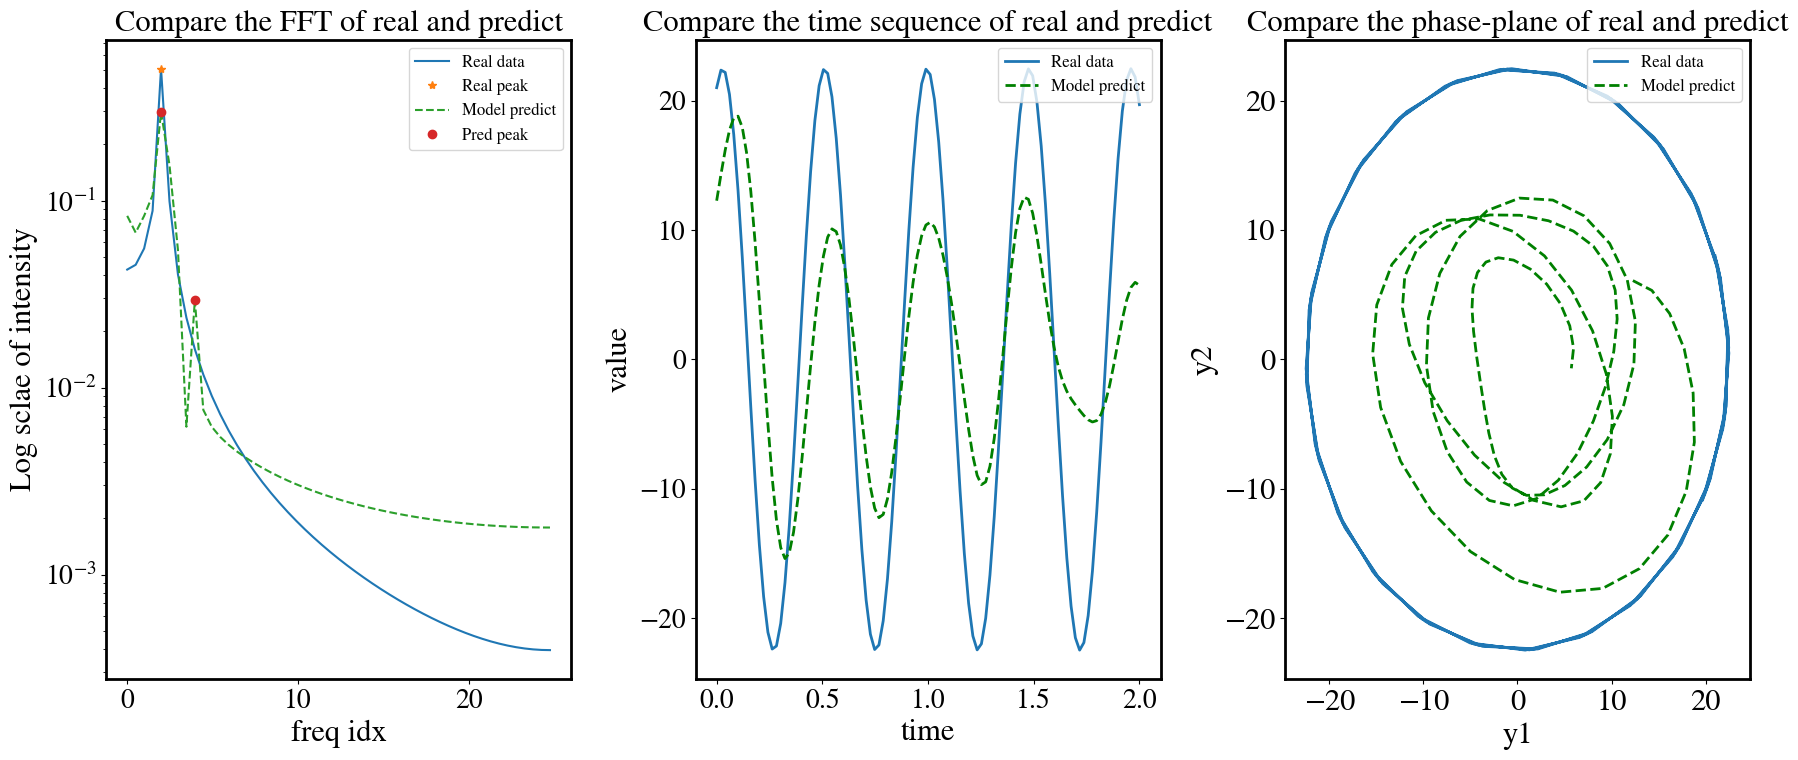

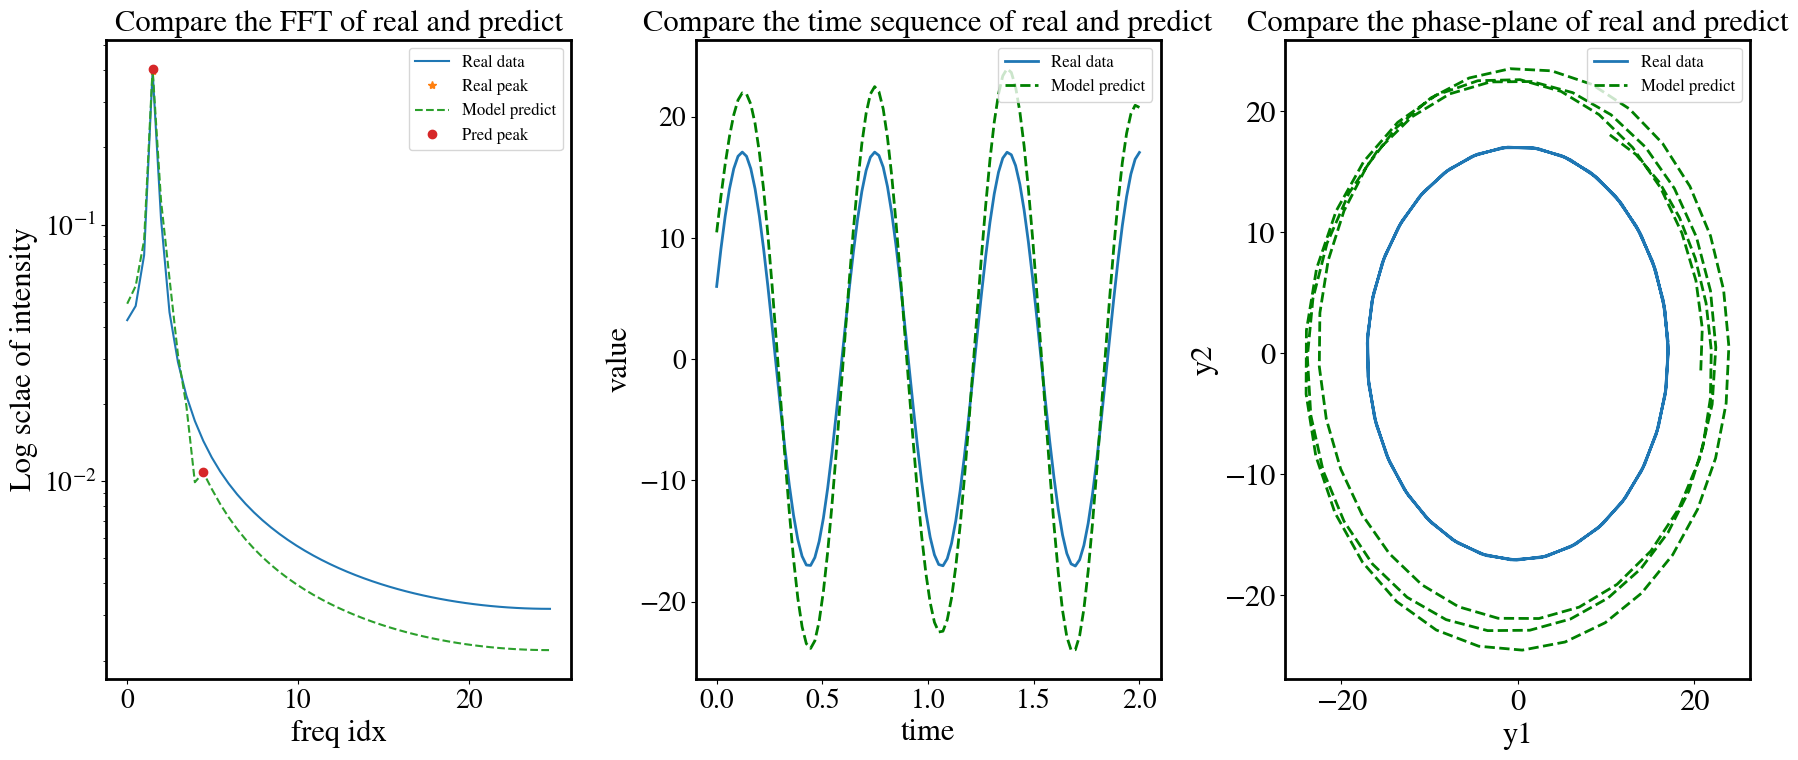

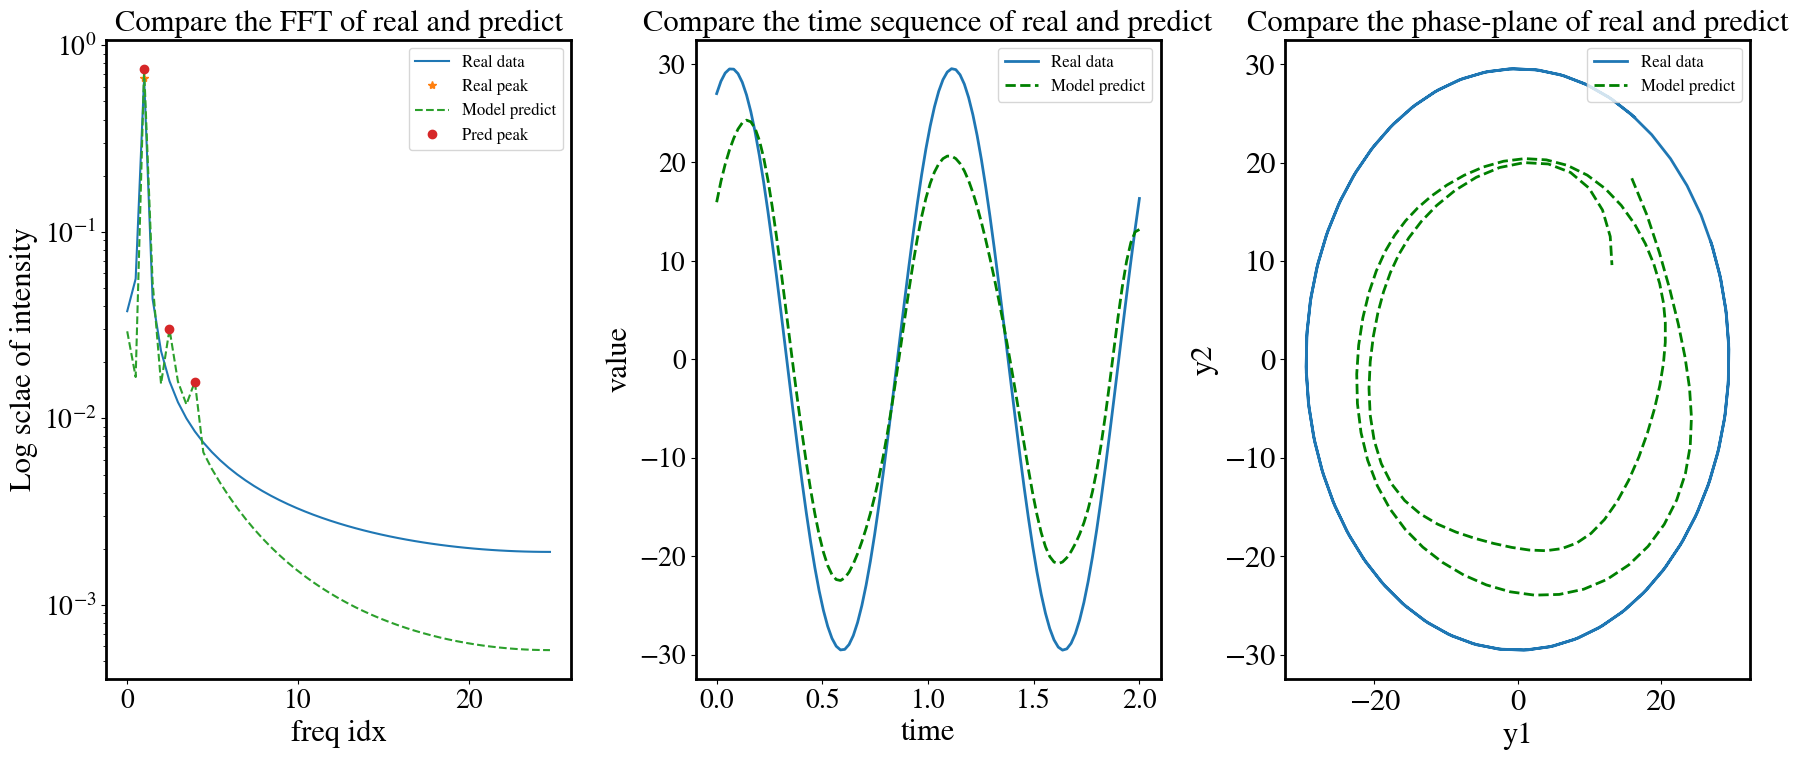

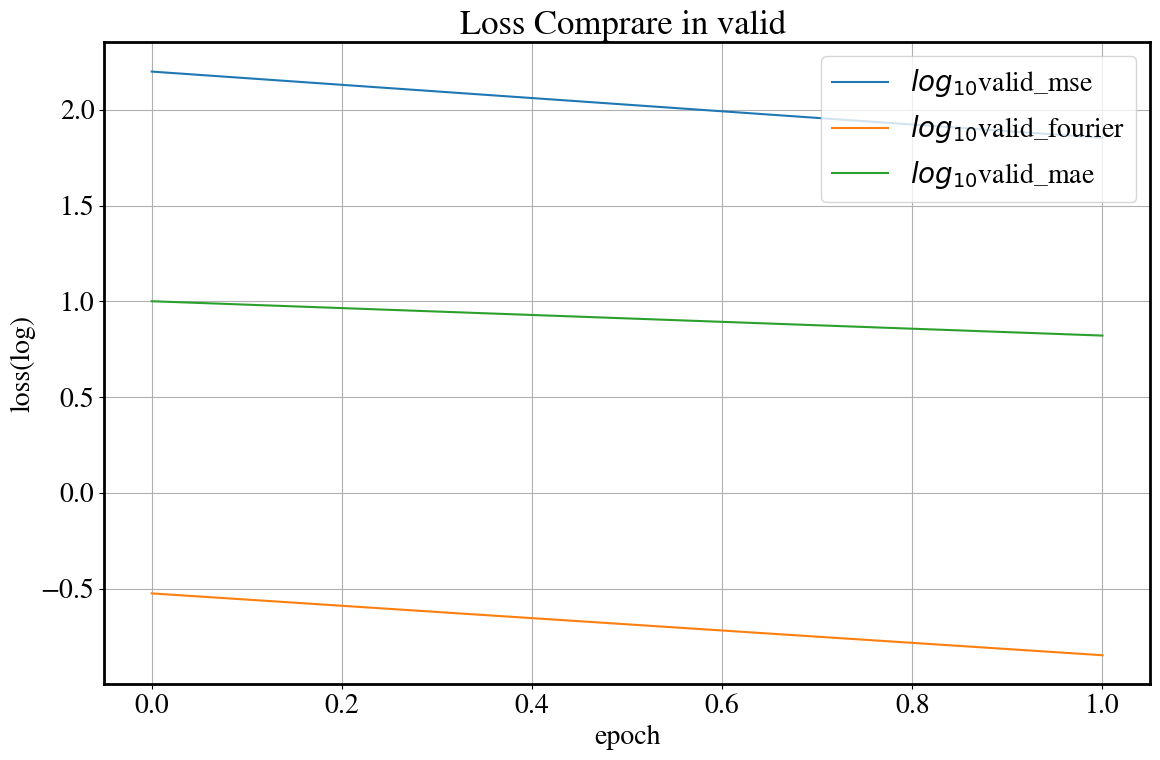

In [50]:
# return test' results
result,co_actor=expr2.do_expr(
                                results_save_path=results_path,
                                folder_num=3,
                                train_config=expr2.config,
                                model_type="inference_net")

## post process 4 visual

In [6]:
import torch
import sympy
from sympy.parsing.sympy_parser import parse_expr

def parse_and_create_function(expr_str):
    """
    解析给定的数学表达式字符串，并创建一个 PyTorch 函数。

    参数:
    expr_str (str): 初等函数的字符串表达式，例如 "x**10 + 4*x"

    返回:
    function: 一个使用 PyTorch 进行计算的函数
    """
    # 解析表达式
    expr = parse_expr(expr_str)

    # 获取表达式中的所有符号（例如 'x'）
    symbols = list(expr.free_symbols)
    if len(symbols) != 1:
        raise ValueError("表达式应该只含有一个自由变量。")

    # 将 sympy 表达式转换为一个可以用 PyTorch 计算的函数
    def function(x):
        # 将 PyTorch 张量转换为 sympy 数值
        x_sympy = {symbols[0]: x.item()}
        # 计算表达式的值
        result = expr.subs(x_sympy)
        # 将结果转换回 PyTorch 张量
        return torch.tensor(float(result))

    return function

# 示例使用
expr_str = " 4*sin(x)"
f = parse_and_create_function(expr_str)

# 使用 PyTorch 张量计算函数值
x_value = torch.tensor([2.0])  # 示例输入
result = f(x_value)
print(result)


tensor(3.6372)
